# VISUALIZATION

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [ ]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import seaborn as sns

from scipy.stats import zscore

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    return seed

# Set seed for reproducibility
seed = set_seed(42)


In [2]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data - Dispersion
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [3]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)

    return results_df

## Pivoting Frequency values to columns

In [4]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [5]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_5_plastics/processed/'

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

# df.head()
df.sample(15)

,Frequency (GHz),LG (mV),HG (mV),Sample
1848767,390.0,2.563789,770.113468,H3_32
797829,500.0,-1.465023,18.923208,D1_4
1820722,150.0,69.954827,-0.244141,H3_32
1838638,300.0,4.395068,-0.000048,H3_32
1688475,560.0,-1.342937,26.736662,G4_37
528499,240.0,0.366256,1.587105,C1_3
1155331,300.0,2.075449,0.366306,E4_47
2748590,310.0,1.465023,447.320235,L5_53
744179,560.0,1.465023,26.248321,C5_57
1002119,570.0,-0.488341,22.952020,D5_58


## Balance Dataset

C:\Users\Danim\AppData\Local\Temp\ipykernel_15408\2752713674.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


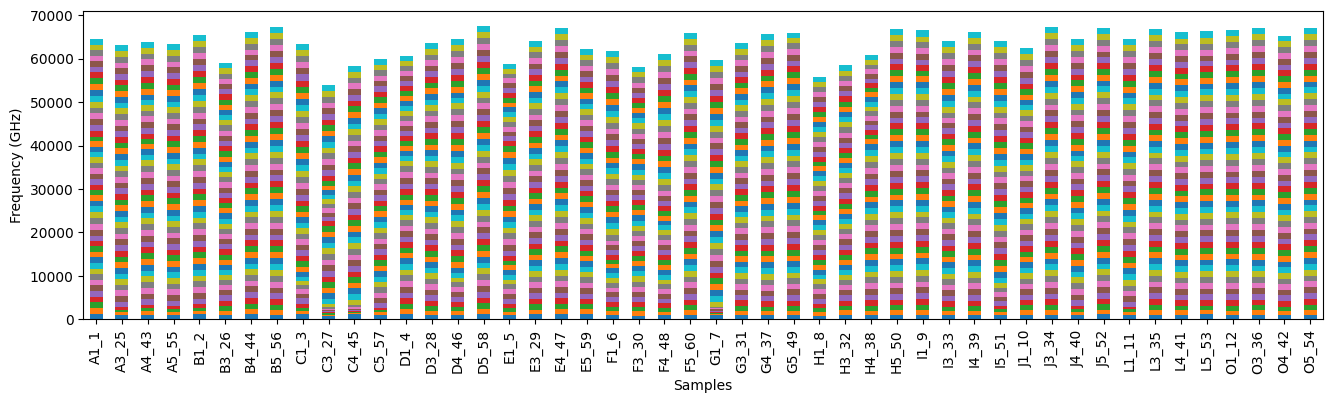

Mean value: 1272


In [ ]:
# Number of samples per frequency and Sample
bx = df.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_xlabel('Samples')
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
bx.get_legend().remove() #remove legend
plt.show()

# Balance the data by taking the mode of samples per frequency
mean= int(df.groupby(['Sample', 'Frequency (GHz)']).size().mean())
print(f'Mean value: {mean}')


# Function to reduce samples to the mean value
def reduce_to_mean(df, sample, frequency, mean):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mean, sample down to the mean
    if len(freq_df) > mean:
        return freq_df.sample(n=mean, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mean(df, sample, frequency, mean))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)

bx = df_balanced.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
# legend small
bx.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
bx.get_legend().remove() #remove legend
plt.show()

## Sample a test set

In [ ]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.2
# train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 
# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42)
# train_set, test_set = train_test_split(df_balanced, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set


## Data Distribution per frequency and Sample

In [ ]:
warnings.filterwarnings('ignore')

train_ex = df_balanced.copy()

print(train_ex.head())

# Create directory for saving PDFs
output_path = os.path.normpath(os.path.join(os.getcwd(), '..', '..', 'data/results/distribution_plots/'))
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create separate PDF for each frequency
for f in train_ex['Frequency (GHz)'].value_counts().index.sort_values().tolist():
    freq = f
    ncols = 4
    nrows = 12
    nums_plastics = 0
    
    # Create individual PDF file for each frequency
    with PdfPages(os.path.join(output_path, f'frequency_{freq}_GHz_distributions.pdf')) as pdf:
        fig, axes = plt.subplots(nrows, ncols, figsize=(14, 20))
        axes = axes.flatten()  # Flatten the axes array
        
        for r in range(nrows * ncols):  # Adjust the loop to iterate over the flattened array
            t = train_ex['Sample'].value_counts().index.sort_values().tolist()
            if nums_plastics < len(t):
                df_tmp = train_ex[(train_ex['Frequency (GHz)'] == freq) & (train_ex['Sample'] == t[nums_plastics])]
                sns.kdeplot(x=df_tmp['LG (mV)'], ax=axes[r], color='#F8766D', label='LG (mV)', fill=True)
                sns.kdeplot(x=df_tmp['HG (mV)'], ax=axes[r], color='#00BFC4', label='HG (mV)', fill=True)
                axes[r].legend(fontsize="small")  # Increased from "xx-small"
                axes[r].set_ylabel('')
                axes[r].set_xlabel('')
                axes[r].set_title(f"Type {t[nums_plastics]} (mV)", fontsize=10)  # Increased from 7
                axes[r].tick_params(labelsize=8, width=0.5)  # Increased from 5
                axes[r].xaxis.offsetText.set_fontsize(8)  # Increased from 6
                axes[r].yaxis.offsetText.set_fontsize(8)  # Increased from 4
                axes[r].set_xlim(-50, 1000)
                nums_plastics += 1
            else:
                axes[r].axis('off')
        
        plt.suptitle(f"All samples. Distribution of LG (mV) and HG (mV) of each plastic to {freq} GHz", 
                    y=0.98, fontsize=12)  # Increased y from 0.93 to 0.98 and fontsize from 10 to 12
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjusted bottom margin from 0.95 to 0.96

        # Save this frequency chart to its individual PDF
        pdf.savefig(fig, bbox_inches='tight', dpi=300, facecolor='white')
        
        plt.show()
        plt.close()  # Close the figure to free memory

print(f"Individual PDF files created for each frequency in: {output_path}")
print("Files created:")
for f in train_ex['Frequency (GHz)'].value_counts().index.sort_values().tolist():
    print(f"- frequency_{f}_GHz_distributions.pdf")

In [ ]:
print('["' + '", "'.join(df_balanced['Sample'].unique()) + '"]') 


In [ ]:
# Print best frequencies for each sample

df_tmp = df_balanced.copy()

# Remove every character of the sample but the first one
df_tmp['Sample'] = df_tmp['Sample'].str[0]

# For every unique sample, calculate and print the mean and standard deviation of HG (mV) for each frequency
unique_samples = df_tmp['Sample'].unique()

for sample in unique_samples:
    sample_df = df_tmp[df_tmp['Sample'] == sample]
    sample_stats = sample_df.groupby('Frequency (GHz)')['HG (mV)'].agg(['mean', 'std']).reset_index()
    
    # Ensure 'mean' column is numeric
    sample_stats['mean'] = pd.to_numeric(sample_stats['mean'], errors='coerce')
    
    # Filter frequencies with mean higher than 50
    filtered_sample_stats = sample_stats[sample_stats['mean'] > 50]
    
    # Sort by standard deviation value
    sorted_sample_stats = filtered_sample_stats.sort_values(by='std', ascending=False)
    
    # Print the sorted list
    print(f"Sample: {sample}")
    print(sorted_sample_stats)


## mV Average with error per frequency

In [ ]:
df_tmp = df_balanced.copy()

# Remove every character of the sample but the first one
df_tmp['Sample'] = df_tmp['Sample'].str[0]

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'O']
# labels = random.sample(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'O'], 4)

# Define a color palette
palette = sns.color_palette("husl", len(labels))

def adjust_color_brightness(color, factor=0.6):
    return tuple([min(1, max(0, c * factor)) for c in color])

with PdfPages('output_plots.pdf') as pdf:
    fig, axes = plt.subplots(12, 1, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, label in enumerate(labels):
        # Filter the DataFrame for the specific sample
        df = df_tmp[df_tmp['Sample'].str.startswith(label)]

        hg_stats = df.groupby(['Sample', 'Frequency (GHz)'])['HG (mV)'].agg(['mean', 'std']).reset_index()
        lg_stats = df.groupby(['Sample', 'Frequency (GHz)'])['LG (mV)'].agg(['mean', 'std']).reset_index()

        # Calculate the upper and lower bounds for HG
        hg_stats['mean_plus_std'] = hg_stats['mean'] + hg_stats['std']
        hg_stats['mean_minus_std'] = hg_stats['mean'] - hg_stats['std']

        # Calculate the upper and lower bounds for LG
        lg_stats['mean_plus_std'] = lg_stats['mean'] + lg_stats['std']
        lg_stats['mean_minus_std'] = lg_stats['mean'] - lg_stats['std']

        # Plot the average HG (mV) with shadow area for mean ± standard deviation
        sns.set_theme(style="whitegrid")

        # Plot mean line for HG
        sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean', marker='', color=palette[i], linewidth=2, label='HG Mean', ax=axes[i])

        # Plot shadow area for HG mean ± 1 std
        axes[i].fill_between(hg_stats['Frequency (GHz)'], hg_stats['mean_minus_std'], hg_stats['mean_plus_std'], color=palette[i], alpha=0.2, label='HG Mean ± Std')

        # Plot mean line for LG with darker color
        darker_color = adjust_color_brightness(palette[i])
        sns.lineplot(data=lg_stats, x='Frequency (GHz)', y='mean', marker='', color=darker_color, linewidth=2, label='LG Mean', ax=axes[i])

        # Plot shadow area for LG mean ± 1 std
        axes[i].fill_between(lg_stats['Frequency (GHz)'], lg_stats['mean_minus_std'], lg_stats['mean_plus_std'], color=darker_color, alpha=0.2, label='LG Mean ± Std', linestyle='--')

        # Add labels and title
        axes[i].set_xlabel('Frequency (GHz)', fontsize=12)
        axes[i].set_ylabel('mV', fontsize=12)
        axes[i].set_title(f'{label}', fontsize=10)

        # Customize legend
        axes[i].legend(fontsize=10, title='Legend', title_fontsize='13')

        # Customize grid and background
        axes[i].grid(True, linestyle='--', alpha=0.6)
        axes[i].set_facecolor('#f9f9f9')

        # # Set y-axis limit
        # axes[i].set_ylim(0, 1200)

        # Set y-axis ticks every 100 units
        axes[i].set_yticks(np.arange(0, 1200, 100))

        # Set x-axis ticks every 50 units
        axes[i].set_xticks(np.arange(100, 600, 50))

    # Add a main title for all charts
    fig.suptitle('Average HG (mV) and LG (mV) with Mean ± Standard Deviation for Each Frequency', fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()
    pdf.savefig(fig)
    plt.close()


In [ ]:
df_tmp = df_balanced.copy()

# Remove every character of the sample but the first one
df_tmp['Sample'] = df_tmp['Sample'].str[0]

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'O']

# Define a color palette
palette = sns.color_palette("husl", len(labels))

def adjust_color_brightness(color, factor=0.6):
    return tuple([min(1, max(0, c * factor)) for c in color])

# Create separate PDF for each sample
for i, label in enumerate(labels):
    # Create individual PDF file for each sample
    with PdfPages(f'output_plot_{label}.pdf') as pdf:
        # Filter the DataFrame for the specific sample
        df = df_tmp[df_tmp['Sample'].str.startswith(label)]

        hg_stats = df.groupby(['Sample', 'Frequency (GHz)'])['HG (mV)'].agg(['mean', 'std']).reset_index()
        lg_stats = df.groupby(['Sample', 'Frequency (GHz)'])['LG (mV)'].agg(['mean', 'std']).reset_index()

        # Calculate the upper and lower bounds for HG
        hg_stats['mean_plus_std'] = hg_stats['mean'] + hg_stats['std']
        hg_stats['mean_minus_std'] = hg_stats['mean'] - hg_stats['std']

        # Calculate the upper and lower bounds for LG
        lg_stats['mean_plus_std'] = lg_stats['mean'] + lg_stats['std']
        lg_stats['mean_minus_std'] = lg_stats['mean'] - lg_stats['std']

        # Create individual figure for this sample
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        
        # Plot the average HG (mV) with shadow area for mean ± standard deviation
        sns.set_theme(style="whitegrid")

        # Plot mean line for HG
        sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean', marker='o', 
                    color=palette[i], linewidth=2, label='HG Mean', ax=ax)

        # Plot shadow area for HG mean ± 1 std
        ax.fill_between(hg_stats['Frequency (GHz)'], hg_stats['mean_minus_std'], 
                       hg_stats['mean_plus_std'], color=palette[i], alpha=0.2, 
                       label='HG Mean ± Std')

        # Plot mean line for LG with darker color
        darker_color = adjust_color_brightness(palette[i])
        sns.lineplot(data=lg_stats, x='Frequency (GHz)', y='mean', marker='s', 
                    color=darker_color, linewidth=2, label='LG Mean', ax=ax)

        # Plot shadow area for LG mean ± 1 std
        ax.fill_between(lg_stats['Frequency (GHz)'], lg_stats['mean_minus_std'], 
                       lg_stats['mean_plus_std'], color=darker_color, alpha=0.2, 
                       label='LG Mean ± Std')

        # Add labels and title
        ax.set_xlabel('Frequency (GHz)', fontsize=14)
        ax.set_ylabel('mV', fontsize=14)
        ax.set_title(f'Sample {label} - Average HG and LG with Mean ± Standard Deviation', 
                    fontsize=16, fontweight='bold')

        # Customize legend
        ax.legend(fontsize=12, title='Legend', title_fontsize='14')

        # Customize grid and background
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_facecolor('#f9f9f9')

        # Set y-axis ticks every 100 units
        ax.set_yticks(np.arange(0, 1200, 100))

        # Set x-axis ticks every 50 units
        ax.set_xticks(np.arange(100, 600, 50))

        plt.tight_layout()
        
        # Save the individual plot to its PDF
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()

print("Individual PDF files created for each sample:")
for label in labels:
    print(f"- output_plot_{label}.pdf")

### Plot average HG (mV) with shadow area for mean ± standard deviation of each of the selected groups of samples


In [ ]:
df_tmp = df_balanced.copy()

labels = [['C1_3', 'C2_15', 'C3_27', 'C4_45'], ['E1_5', 'E2_17', 'E3_29', 'E4_47']]

labels = [
    ["A1_1", "A2_13", "A3_25", "A4_43"],
    ["B1_2", "B2_14", "B3_26", "B4_44"],
    ["C1_3", "C2_15", "C3_27", "C4_45"],
    ["D1_4", "D2_16", "D3_28", "D4_46"],
    # ["E1_5", "E2_17", "E3_29", "E4_47"],
    # ["F1_6", "F2_18", "F3_30", "F4_48"],
    # ["G1_7", "G2_19", "G3_31", "G4_37"],
    # ["H1_8", "H2_20", "H3_32", "H4_38"],
    # ["I1_9", "I2_21", "I3_33", "I4_39"],
    # ["J1_10", "J2_22", "J3_34", "J4_40"],
    # ["L1_11", "L2_23", "L3_35", "L4_41"],
    # ["O1_12", "O2_24", "O3_36", "O4_42"]
]

with PdfPages('output_charts.pdf') as pdf:
    plt.figure(figsize=(14, 6))
    sns.set_theme(style="whitegrid")

    for label_group in labels:
        # Filter the DataFrame for the specific group of samples
        df_group = df_tmp[df_tmp['Sample'].isin(label_group)]

        # Calculate mean and std deviation for the group
        group_stats = df_group.groupby('Frequency (GHz)')['HG (mV)'].agg(['mean', 'std']).reset_index()

        # Calculate the upper and lower bounds
        group_stats['mean_plus_std'] = group_stats['mean'] + group_stats['std']
        group_stats['mean_minus_std'] = group_stats['mean'] - group_stats['std']

        # Plot mean line
        sns.lineplot(data=group_stats, x='Frequency (GHz)', y='mean', marker='', label=f'{label_group} Mean')

        # Plot shadow area for mean ± 1 std
        plt.fill_between(group_stats['Frequency (GHz)'], group_stats['mean_minus_std'], group_stats['mean_plus_std'], alpha=0.2, label=f'{label_group} Mean ± Std')

    # Add labels and title
    plt.xlabel('Frequency (GHz)', fontsize=12)
    plt.ylabel('HG (mV)', fontsize=12)
    plt.title('Average HG (mV) with Mean ± Standard Deviation for Each Group of Samples', fontsize=16)

    # X axis space adjustment (show 1 of each 2 ticks)
    plt.xticks(group_stats['Frequency (GHz)'].unique(), rotation=45)

    # Customize legend
    plt.legend(fontsize=10, title='Legend', title_fontsize='13')

    # Customize grid and background
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_facecolor('#f9f9f9')

    # Save plot to PDF
    pdf.savefig()
    plt.close()

print("Charts saved as output_charts.pdf")


In [ ]:
df_tmp = df_balanced.copy()

labels = [
    ["A1_1", "A2_13", "A3_25", "A4_43"],
    ["B1_2", "B2_14", "B3_26", "B4_44"],
    ["C1_3", "C2_15", "C3_27", "C4_45"],
    ["D1_4", "D2_16", "D3_28", "D4_46"],
    # ["E1_5", "E2_17", "E3_29", "E4_47"],
    # ["F1_6", "F2_18", "F3_30", "F4_48"],
    # ["G1_7", "G2_19", "G3_31", "G4_37"],
    # ["H1_8", "H2_20", "H3_32", "H4_38"],
    # ["I1_9", "I2_21", "I3_33", "I4_39"],
    # ["J1_10", "J2_22", "J3_34", "J4_40"],
    # ["L1_11", "L2_23", "L3_35", "L4_41"],
    # ["O1_12", "O2_24", "O3_36", "O4_42"]
]

with PdfPages('output_charts_error_bar.pdf') as pdf:
    plt.figure(figsize=(14, 6))
    sns.set_theme(style="whitegrid")

    for label_group in labels:
        # Filter the DataFrame for the specific group of samples
        df_group = df_tmp[df_tmp['Sample'].isin(label_group)]

        # Calculate mean and std deviation for the group
        group_stats = df_group.groupby('Frequency (GHz)')['HG (mV)'].agg(['mean', 'std']).reset_index()

        # Plot mean line with error bars for std deviation
        plt.errorbar(group_stats['Frequency (GHz)'], group_stats['mean'], yerr=group_stats['std'], fmt='-o', label=f'{label_group} Mean ± Std', linewidth=1, capsize=3)

    # Add labels and title
    plt.xlabel('Frequency (GHz)', fontsize=12)
    plt.ylabel('HG (mV)', fontsize=12)
    plt.title('Average HG (mV) with Mean ± Standard Deviation for Each Group of Samples', fontsize=16)

    # X axis space adjustment (show 1 of each 2 ticks)
    plt.xticks(group_stats['Frequency (GHz)'].unique(), rotation=45)

    # Customize legend
    plt.legend(fontsize=10, title='Legend', title_fontsize='13')

    # Customize grid and background
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_facecolor('#f9f9f9')

    # Save plot to PDF
    pdf.savefig()
    plt.close()

print("Charts saved as output_charts_error_bar.pdf")


## Data Windowing



In [ ]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
data_percentage = (100/(27*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(27*(test_percentage)))*time_window_s

data_percentage = 0
data_percentage_test = 0

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)

# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

#Save the processed data to a CSV file

# output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)


## Clustering

In [ ]:
# Unsupervised clusterization of every sample for each frequency
# Define the number of clusters
n_clusters = 15

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
])

# Define the frequencies and samples
frequencies = train_ex['Frequency (GHz)'].unique()
samples = train_ex['Sample'].unique()

# Define the 14 colors and markers
# Define 14 colors and markers
colors = ['#F8766D', '#00BFC4', '#7CAE00', '#C77CFF', '#FF61C3', '#00BA38', '#619CFF', '#F564E3', '#00A9FF', '#FF9F00', '#00BFC4', '#F8766D', '#7CAE00', '#C77CFF', '#FF61C3']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'd', 'P', 'X', '8']

# Create subplots
ncols = 5
nrows = int(np.ceil(len(frequencies) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4), sharex=True, sharey=True)

# Ensure axes is iterable
axes = axes.flatten()

# Loop over frequencies
for idx, f in enumerate(frequencies):
    n_samples = 0
    # Loop over samples
    for s in samples:
        # Filter the DataFrame
        df_tmp = train_ex[(train_ex['Frequency (GHz)'] == f) & (train_ex['Sample'] == s)]
        # Check if there are enough samples
        if len(df_tmp) >= n_clusters:
            # Fit the pipeline
            pipe.fit(df_tmp[['LG (mV)', 'HG (mV)']])
            # Get the cluster labels
            labels = pipe.named_steps['kmeans'].labels_
            # Plot the data
            axes[idx].scatter(df_tmp['LG (mV)'], df_tmp['HG (mV)'],
                              color=colors[n_samples % len(colors)],
                              marker=markers[n_samples % len(markers)],
                              label=s)
            axes[idx].set_title(f"Frequency {f} GHz")
            axes[idx].set_xlabel('LG (mV)')
            axes[idx].set_ylabel('HG (mV)')
            axes[idx].legend(fontsize='xx-small')
            n_samples += 1

# Hide any unused subplots
for ax in axes[len(frequencies):]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.5)

# # Save plots
# output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/plots/all_samples_distribution_per_freq'
# if not os.path.exists(output_path):
#     os.makedirs(output_path)
# plt.savefig(f"{output_path}/data_distribution_per_freq_{freq}.png", dpi=500)
plt.show()


## Sample a test set

In [ ]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.25
# train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 
# Shuffle the data
df_balanced_ = df_balanced.sample(frac=1, random_state=42)
train_set, test_set = train_test_split(df_balanced_, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [ ]:
train_ex = train_set.copy()

In [ ]:
train_ex.info()
# train_ex.describe()

In [ ]:

ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
# ax = test_set['Frequency (GHz)'].plot.hist(ax=ax, bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
data_percentage = (100/(27*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(27*(test_percentage)))*time_window_s

data_percentage = 0
data_percentage_test = 0

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)

# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

#Save the processed data to a CSV file

output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)



In [ ]:
print(f"Train set shape: {train_set_test.shape}")
print(f"Test set shape: {test_set_test.shape}")
print(train_set_test.head())
print(test_set.shape)


In [ ]:
# Define the two frequencies to be used as axes
var1 = '370.0 HG (mV)'
var2 = '420.0 HG (mV)'

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_set_test, x=var1, y=var2, hue='Sample', palette='tab10', s=25, alpha=0.7)

# Add labels and title
plt.xlabel(f'{var1}')
plt.ylabel(f'{var2}')
plt.title(f'Scatter Plot of Samples for {var1} vs {var2}')

# Customize legend
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add sample names to clusters
for sample in train_set_test['Sample'].unique():
    sample_data = train_set_test[train_set_test['Sample'] == sample]
    cluster_center = sample_data[[var1, var2]].mean()
    plt.text(cluster_center[var1], cluster_center[var2], sample, fontsize=9, weight='bold')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

input_size, output_size

# print(f'input_size: {input_size}, output_size: {output_size}')
# print(X_train, y_train)